# Predicting sequences with LSTM

We will use a different type of network with a different structure, called **long short-term memory** (LSTM).


#### 1. Read some time series data

In [60]:
import pandas as pd
import numpy as np
orig_df = pd.read_csv("./data/retail_sales.csv", index_col='date')

In [61]:
print("First five rows")
orig_df.head()

First five rows


,sales
date,
2009-10-01,338630
2009-11-01,339386
2009-12-01,400264
2010-01-01,314640
2010-02-01,311022


In [62]:
print("Last five rows")
orig_df.tail()

Last five rows


,sales
date,
2015-05-01,462615
2015-06-01,448229
2015-07-01,457710
2015-08-01,456340
2015-09-01,430917


Time series value


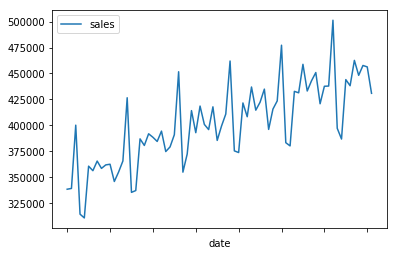

In [63]:
print("Time series value")
orig_df.plot()

In [64]:
print("Make a copy of orig_df into df using the .copy() method")
df = orig_df.copy()

Make a copy of orig_df into df using the .copy() method


#### 2. Baseline model for time series prediction

Let's set up a simple benchmark. We will forecast, at the beginning of the month, that the value will be the value from the previous month.

In [65]:
# Baseline prediction: at the beginning of the month, predict the value of the previous month
df['Baseline Prediction'] = df.shift(1)

In [66]:
print("First five rows")
df.head()

First five rows


,sales,Baseline Prediction
date,,
2009-10-01,338630,NaN
2009-11-01,339386,338630.0
2009-12-01,400264,339386.0
2010-01-01,314640,400264.0
2010-02-01,311022,314640.0


In [67]:
print("Preprocessing step: Replace the nan value by 10.22")
from sklearn.metrics import mean_squared_error
df.fillna(value=10.22,axis=0, inplace=True)

Preprocessing step: Replace the nan value by 10.22


**Mean squared error of our baseline and see how it looks**

In [68]:
print("Mean squared error of the baseline model")
mean_squared_error(df['sales'],df['Baseline Prediction'])

Mean squared error of the baseline model


2992418048.5590057

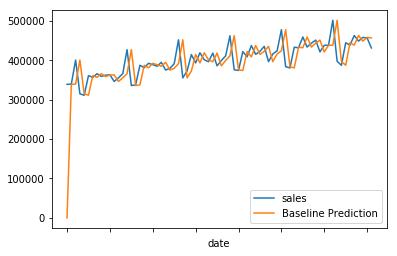

In [69]:
df.plot()

In [70]:
df['y'] = df['sales'].shift(-1)

In [71]:
df.drop('Baseline Prediction', axis=1, inplace=True)

#### 3. Preprocessing

Time series data usually has some trend, and this might make things difficult to predict. 

One way of dealing with trends is to take differences instead. 

We will also normalize the values so that everything stays between -1 and 1.


In [72]:
print("Use the .diff() method to take differences automatically")
df.diff().head()

Use the .diff() method to take differences automatically


,sales,y
date,,
2009-10-01,NaN,NaN
2009-11-01,756.0,60878.0
2009-12-01,60878.0,-85624.0
2010-01-01,-85624.0,-3618.0
2010-02-01,-3618.0,49797.0


In [73]:
df.diff().tail()

,sales,y
date,,
2015-05-01,24398.0,-14386.0
2015-06-01,-14386.0,9481.0
2015-07-01,9481.0,-1370.0
2015-08-01,-1370.0,-25423.0
2015-09-01,-25423.0,NaN


In [74]:
df = df.diff()

In [75]:
df.fillna(value=df['y'].mean(),axis=0, inplace=True)

In [76]:
from sklearn.preprocessing import MinMaxScaler
scl = MinMaxScaler(feature_range=(-1,1))

#### 4. Dividing between training and testing.

As the information is coming sequentially, it makes more sense to split between training and validation in the natural order it happens.

In [77]:
train_idx = int(0.8*len(df))
train, test = df.values[0:-train_idx], df.values[-train_idx:]

In [78]:
train = scl.fit_transform(train)
test = scl.transform(test)

In [79]:
X_train, y_train = train[:,0:-1], train[:,-1]
X_test, y_test = test[:,0:-1], test[:,-1]

The LSTM layer expects input as 
- **samples**: independent observations.
- **timesteps**: the same sample measured during different time steps. Here we have 1 sample = 1 time step.
- **features**: the usual attributes.


In [80]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [81]:
batch_size = 1
n_epochs = 100
neurons = 4

In [82]:
from keras.models import Sequential
from keras.layers import LSTM,Dense
model = Sequential()
model.add(
    LSTM(neurons, 
               batch_input_shape=(batch_size, X_train.shape[1], X_train.shape[2]), stateful=True)
         )
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [83]:
model.fit(X_train,y_train, epochs=n_epochs, batch_size=batch_size, verbose=0)

In [84]:
preds = model.predict(X_test, batch_size=batch_size)

In [85]:
X_test.shape

(57, 1, 1)

In [86]:
preds.shape

(57, 1)

In [87]:
reshaped_preds = scl.inverse_transform(np.hstack([X_test.reshape(X_test.shape[0],X_test.shape[2]),preds]))

In [88]:
reshaped_preds = np.concatenate([X_test.reshape(X_test.shape[0],1),preds], axis=1)

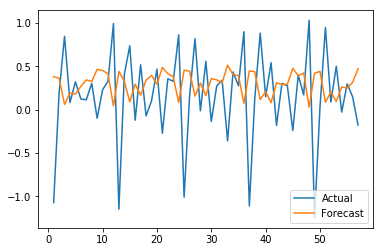

In [89]:
pd.DataFrame(data = reshaped_preds, columns = ['Actual','Forecast'], 
             index=range(1,train_idx+1)).plot()

In [28]:
mean_squared_error(reshaped_preds[:,0], reshaped_preds[:,1])

0.0073111948883077425